In [1]:
!pip install conllu
!pip install transformers-interpret

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

# Verify current working directory
print("Current working directory:", os.getcwd())

Current working directory: /content


In [4]:
# imports
from sklearn.model_selection import train_test_split as split
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers_interpret import SequenceClassificationExplainer
from collections import defaultdict
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer
from transformers import AutoModelForSequenceClassification, DistilBertConfig

In [5]:
# custom imports
import sys
import pandas as pd

sys.path.append('/content/drive/MyDrive/06_TUWien/09_NLP/src')
from data_util import load_data
from dbert import extract_data, encode_data, dataloader, train_bert, plot_metrics, test_bert

#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ovsvc (ovsvc-tu-wien). Use `wandb login --relogin` to force relogin


#### Data import

In [6]:
# load the data
#path = "../data/dataset.conllu"
path= "/content/drive/MyDrive/06_TUWien/09_NLP/data/dataset.conllu"
headlines = load_data(path)

#train test validation split
SEED = 42
tr_data, other_data = split(headlines, test_size=0.3, random_state=SEED)
val_data, ts_data = split(other_data, test_size=0.5, random_state=SEED)
print(f"Number of headlines for training, validation, and test is {len(tr_data)}, {len(val_data)}, and {len(ts_data)} resp.")

Number of headlines for training, validation, and test is 20033, 4293, and 4293 resp.


In [7]:
#Get texts and labels from the data
tr_texts, tr_labels = extract_data(tr_data)
val_texts, val_labels = extract_data(val_data)
ts_texts, ts_labels = extract_data(ts_data)

#### Data prep

In [8]:
# Initialize the BERT tokenizer
pretrained_model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
# Tokenize data
tr_tokens, tr_atention = encode_data(tr_texts, tokenizer)
val_tokens, val_atention = encode_data(val_texts, tokenizer)
ts_tokens, ts_atention = encode_data(ts_texts, tokenizer)

In [10]:
# Prepaire data for the model
train = dataloader(tr_tokens, tr_atention, tr_labels, tr_texts, batch_size=8, isTrain = True)
validation = dataloader(val_tokens, val_atention, val_labels, val_texts, batch_size=8)
test = dataloader(ts_tokens, ts_atention, ts_labels, ts_texts, batch_size=8)

#### Model setup

In [11]:
# Load the DistilBERT model's configuration
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')

# Labels
id2label = {0: "not_sarcastic", 1: "sarcastic"}
label2id = {"not_sarcastic": 0, "sarcastic": 1}

# Modify the dropout rates (increase them as needed)
config.attention_probs_dropout_prob = 0.25  # Default is 0.1
config.hidden_dropout_prob = 0.25  # Default is 0.1
config.num_labels = 2
config.id2label = id2label
config.label2id = label2id


model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    config=config
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Train DistilBERT Model

In [12]:
# We only want to finetune the classification layer on top of BERT
for p in model.base_model.parameters():
    p.requires_grad = False


for p in model.classifier.parameters():
    print(p.requires_grad)  # Check trainable status

True
True


In [13]:
from tqdm import tqdm  # Standard tqdm for scripts
from tqdm.notebook import tqdm as notebook_tqdm

best_acc, val_loss, train_loss, val_acc, train_acc = train_bert(
    model=model,
    trainloader=train,
    validationloader=validation,
    device=device,
    epochs=10,
    patience=5
)
print(f"Best Validation Accuracy: {best_acc:.4f}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training for 10 epochs with early stopping (patience=5).

Epoch 1/10


Training: 100%|██████████| 2504/2504 [00:37<00:00, 67.43batch/s, loss=0.682]


Total loss: 1474.7806, Training Loss: 0.0736, Training Accuracy: 0.6933


Validation: 100%|██████████| 536/536 [00:04<00:00, 114.15batch/s]


Validation Loss: 0.0586, Validation Accuracy: 0.7887
Validation accuracy improved. Best model updated.

Epoch 2/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 71.93batch/s, loss=0.503]


Total loss: 1119.8251, Training Loss: 0.0559, Training Accuracy: 0.7965


Validation: 100%|██████████| 536/536 [00:04<00:00, 133.70batch/s]


Validation Loss: 0.0510, Validation Accuracy: 0.8176
Validation accuracy improved. Best model updated.

Epoch 3/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 73.62batch/s, loss=0.515]


Total loss: 1039.7960, Training Loss: 0.0519, Training Accuracy: 0.8112


Validation: 100%|██████████| 536/536 [00:04<00:00, 110.36batch/s]


Validation Loss: 0.0483, Validation Accuracy: 0.8281
Validation accuracy improved. Best model updated.

Epoch 4/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 73.33batch/s, loss=0.557]


Total loss: 993.8879, Training Loss: 0.0496, Training Accuracy: 0.8208


Validation: 100%|██████████| 536/536 [00:03<00:00, 135.38batch/s]


Validation Loss: 0.0469, Validation Accuracy: 0.8328
Validation accuracy improved. Best model updated.

Epoch 5/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 73.08batch/s, loss=0.594]


Total loss: 980.7792, Training Loss: 0.0490, Training Accuracy: 0.8248


Validation: 100%|██████████| 536/536 [00:05<00:00, 97.95batch/s] 


Validation Loss: 0.0461, Validation Accuracy: 0.8358
Validation accuracy improved. Best model updated.

Epoch 6/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 73.50batch/s, loss=0.477]


Total loss: 957.7796, Training Loss: 0.0478, Training Accuracy: 0.8275


Validation: 100%|██████████| 536/536 [00:04<00:00, 132.44batch/s]


Validation Loss: 0.0455, Validation Accuracy: 0.8388
Validation accuracy improved. Best model updated.

Epoch 7/10


Training: 100%|██████████| 2504/2504 [00:35<00:00, 71.08batch/s, loss=0.626]


Total loss: 944.3740, Training Loss: 0.0471, Training Accuracy: 0.8303


Validation: 100%|██████████| 536/536 [00:05<00:00, 104.56batch/s]


Validation Loss: 0.0451, Validation Accuracy: 0.8386
No improvement in validation for 1 consecutive epoch(s).

Epoch 8/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 72.65batch/s, loss=0.534]


Total loss: 936.5252, Training Loss: 0.0467, Training Accuracy: 0.8340


Validation: 100%|██████████| 536/536 [00:03<00:00, 135.93batch/s]


Validation Loss: 0.0450, Validation Accuracy: 0.8390
Validation accuracy improved. Best model updated.

Epoch 9/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 72.04batch/s, loss=0.646]


Total loss: 933.8253, Training Loss: 0.0466, Training Accuracy: 0.8344


Validation: 100%|██████████| 536/536 [00:05<00:00, 106.18batch/s]


Validation Loss: 0.0449, Validation Accuracy: 0.8393
Validation accuracy improved. Best model updated.

Epoch 10/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 73.02batch/s, loss=0.377]


Total loss: 925.4042, Training Loss: 0.0462, Training Accuracy: 0.8350


Validation: 100%|██████████| 536/536 [00:03<00:00, 134.35batch/s]

Validation Loss: 0.0448, Validation Accuracy: 0.8386
No improvement in validation for 1 consecutive epoch(s).
Training completed.
Best Validation Accuracy: 0.8393


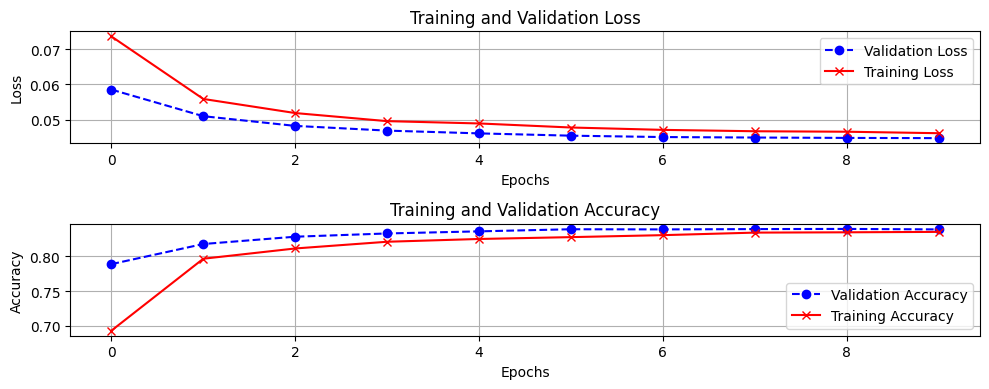

In [14]:
# Train vs validation metrics
plot_metrics(val_loss, train_loss, val_acc, train_acc)

#### Misclass analysis - quantitative

In [13]:
model.load_state_dict(torch.load("/content/best_model.pth"))
model.to(device)
test_metrics = test_bert(model, test, device)

<ipython-input-13-3ef9401ae220>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_model.pth"))
Testing: 100%|██████████| 536/5


Test Metrics:
Loss: 0.0448
Accuracy: 0.8389
Precision: 0.8451
Recall: 0.8127
F1-Score: 0.8286
ROC-AUC: 0.9214
MCC: 0.6771
Confusion Matrix:
[[1927  306]
 [ 385 1670]]


In [14]:
#Store predictions on the test set & misclass cases into df
df = test_metrics["df"]

mismatched_df = df[df['True Label'] != df['Predicted Label']]
mismatched_df

,True Label,Predicted Label,Probability,Sentences
1,1,0.0,0.298275,study owning a boat not worth it
12,1,0.0,0.328836,gay conversion therapists claim most patients ...
13,1,0.0,0.463182,repopulation of africa begins
26,0,1.0,0.758528,white terror demands white action what allies ...
31,0,1.0,0.665922,surge soda is back
...,...,...,...,...
4251,1,0.0,0.360188,delirious rover hallucinates water on mars
4255,1,0.0,0.245440,israeli soldiers open fire on palestinians car...
4260,0,1.0,0.614402,radio host pranks the out of cohost
4267,1,0.0,0.050599,mom wants to know if the people who live in yo...


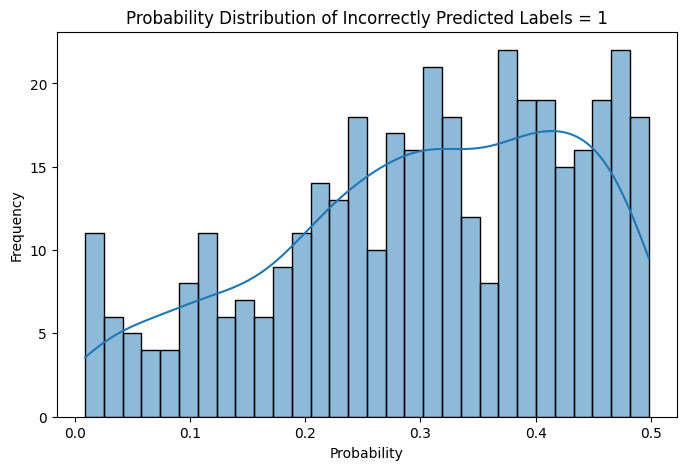

In [15]:
# Create the probability distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(mismatched_df[mismatched_df['True Label']== 1.0]['Probability'], bins = 30, kde=True)
plt.title('Probability Distribution of Incorrectly Predicted Labels = 1')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

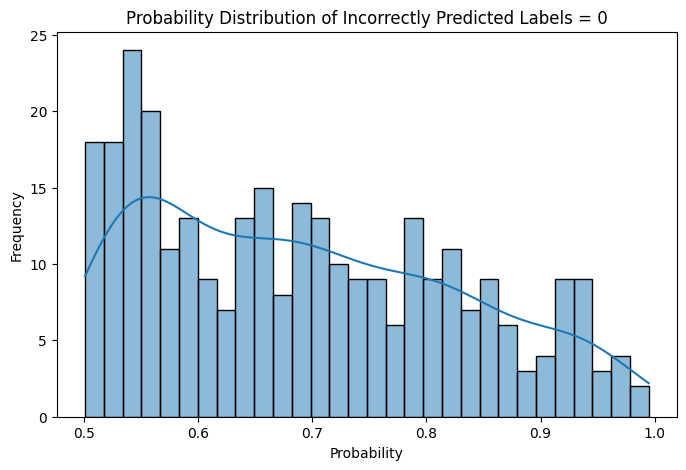

In [16]:
# Create the probability distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(mismatched_df[mismatched_df['True Label']== 0]['Probability'], bins = 30, kde=True)
plt.title('Probability Distribution of Incorrectly Predicted Labels = 0')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

Model is not confident near the borders

In [17]:
target_names = target_names = ['Not Sarcastic', 'Sarcastic']
print(classification_report(df["True Label"], df["Predicted Label"], target_names = target_names))

               precision    recall  f1-score   support

Not Sarcastic       0.83      0.86      0.85      2233
    Sarcastic       0.85      0.81      0.83      2055

     accuracy                           0.84      4288
    macro avg       0.84      0.84      0.84      4288
 weighted avg       0.84      0.84      0.84      4288



#### Misclass - tokens

In [18]:
binary_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)

In [19]:
def interpret_sentence(sentence):
  word_attributions = binary_explainer(sentence)
  return binary_explainer.visualize()

misclass_sentences = list(mismatched_df["Sentences"])
predicted_labels = list(mismatched_df["Predicted Label"])

for sentence in range(10):
    print(f"Sentence: {misclass_sentences[sentence]}")
    print(f"Predicted Label: {predicted_labels[sentence]}")
    interpret_sentence(misclass_sentences[sentence])

Sentence: study owning a boat not worth it
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.72),not_sarcastic,0.82,[CLS] study owning a boat not worth it [SEP]


Sentence: gay conversion therapists claim most patients fully straight by the time they commit suicide
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.74),not_sarcastic,1.92,[CLS] gay conversion therapist ##s claim most patients fully straight by the time they commit suicide [SEP]


Sentence: repopulation of africa begins
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.52),not_sarcastic,0.14,[CLS] rep ##op ##ulation of africa begins [SEP]


Sentence: white terror demands white action what allies need to do right now for charlottesville
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.71),sarcastic,-0.58,[CLS] white terror demands white action what allies need to do right now for charlotte ##sville [SEP]


Sentence: surge soda is back
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.66),sarcastic,0.68,[CLS] surge soda is back [SEP]


Sentence: supreme court upholds bill of rights in 54 decision
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.76),not_sarcastic,1.42,[CLS] supreme court uphold ##s bill of rights in 54 decision [SEP]


Sentence: interview with louise munson playwright of luigi
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.50),sarcastic,-0.40,[CLS] interview with louise mu ##nson playwright of luigi [SEP]


Sentence: exxonmobil swears its going to start taxes early this year
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.55),not_sarcastic,1.32,[CLS] ex ##xon ##mo ##bil swear ##s its going to start taxes early this year [SEP]


Sentence: biden calls dibs on qaddafis clothes
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.76),not_sarcastic,1.38,[CLS] bid ##en calls di ##bs on q ##ad ##da ##fi ##s clothes [SEP]


Sentence: cupid cop gave out roses cards on valentines day instead of tickets
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.63),sarcastic,-0.63,[CLS] cup ##id cop gave out roses cards on valentine ##s day instead of tickets [SEP]


In [20]:
# Initialize dictionaries to store positive and negative counts for each token
positive_token_counts = defaultdict(int)
negative_token_counts = defaultdict(int)

# Define a function to interpret a sentence and aggregate scores
def interpret_sentence_and_aggregate(sentence ):
    word_attributions = binary_explainer(sentence)

    # Extract tokens and scores from word_attributions
    for token, score in word_attributions:  # Assuming word_attributions is a list of (token, score)
        if score > 0:
            positive_token_counts[token] += 1
        elif score < 0:
            negative_token_counts[token] += 1

# Iterate over sentences
misclass_sentences = list(mismatched_df["Sentences"])
predicted_labels = list(mismatched_df["Predicted Label"])

for sentence in misclass_sentences:
    interpret_sentence_and_aggregate(sentence)

In [21]:
# Calculate total counts for positive and negative tokens
total_positive_tokens = sum(positive_token_counts.values())
total_negative_tokens = sum(negative_token_counts.values())

# Calculate percentage contributions
positive_token_percentages = {
    token: (count / total_positive_tokens) * 100 for token, count in positive_token_counts.items()
}
negative_token_percentages = {
    token: (count / total_negative_tokens) * 100 for token, count in negative_token_counts.items()
}

# Sort and get top 10 tokens for positive and negative percentages
top_positive_tokens = sorted(positive_token_percentages.items(), key=lambda x: x[1], reverse=True)[:20]
top_negative_tokens = sorted(negative_token_percentages.items(), key=lambda x: x[1], reverse=True)[:20]

# Print the top 10 results with percentages
print("Top 10 tokens more often positive (as percentage of total):")
for token, percentage in top_positive_tokens:
    print(f"{token}: {percentage:.2f}%")

print("\nTop 10 tokens more often negative (as percentage of total):")
for token, percentage in top_negative_tokens:
    print(f"{token}: {percentage:.2f}%")


Top 10 tokens more often positive (as percentage of total):
to: 2.62%
##s: 2.12%
of: 1.83%
in: 1.26%
for: 1.22%
the: 0.95%
on: 0.68%
a: 0.56%
trump: 0.56%
you: 0.54%
at: 0.49%
from: 0.45%
by: 0.43%
after: 0.41%
up: 0.37%
who: 0.37%
out: 0.35%
and: 0.35%
man: 0.35%
new: 0.35%

Top 10 tokens more often negative (as percentage of total):
to: 3.35%
##s: 2.19%
of: 2.10%
in: 1.72%
for: 1.19%
on: 0.94%
a: 0.94%
new: 0.78%
the: 0.75%
with: 0.69%
and: 0.56%
##t: 0.53%
by: 0.53%
trump: 0.50%
after: 0.47%
at: 0.41%
this: 0.34%
##ing: 0.31%
his: 0.31%
from: 0.31%
